<a href="https://colab.research.google.com/github/condusinew/vaccine_failure_escape/blob/main/SIR_mode_natimm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\frac{\mathrm{d}S}{\mathrm{d}t} = -(\beta_r I_r + \beta_v I_v)S$

$\frac{\mathrm{d}I_r}{\mathrm{d}t} = \beta_r I_r [S+N+(1-\epsilon_L) P] - \gamma_r I_r $

$\frac{\mathrm{d}N}{\mathrm{d}t} = (1-\epsilon_a)\gamma_rI_r - (\beta_v I_v + \beta_r I_r) N $

$\frac{\mathrm{d}P}{\mathrm{d}t} = \epsilon_a\gamma_rI_r - \beta_r I_r(1-\epsilon_L)P - \beta_v I_v (1-(1-\mu)\epsilon_L) P$

$\frac{\mathrm{d}I_v}{\mathrm{d}t} = \beta_v I_v [S + N + (1-(1-\mu)\epsilon_L)] P - \gamma_v I_v$

$\frac{\mathrm{d}I_v}{\mathrm{d}t} = \gamma_v I_v$

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# SIR model equations
def SIR_model_rv(t, y, mu, betar, gammar, betav, gammav, epsilona, epsilonL):
    S, Iw, N, P, Im, Rv, CIw, CIm  = y


    dSdt = -(betar*Iw+ betav*Im) * S
    dIwdt = betar * Iw* (S + N + (1-epsilonL)*P)  - gammar * Iw

    dNdt = (1-epsilona)*gammar * Iw- (betav*Im+betar*Iw)*N
    dPdt = epsilona * gammar * Iw- betar*Iw*(1-epsilonL)*P - betav*Im*(1-((1-mu)*epsilonL))*P

    dImdt = betav*Im*(S + N +(1-((1-mu)*epsilonL))*P) - gammav * Im
    dRvdt = gammav * Im

    #will include indImiduals that get reinfected as multiple infections
    #cumulatIme infections
    dCIwdt = betar * Iw* (S + N + (1-epsilonL)*P)
    dCImdt = betav*Im*(S + N +(1-((1-mu)*epsilonL))*P)


    return [dSdt, dIwdt, dNdt, dPdt, dImdt, dRvdt, dCIwdt, dCImdt]

#basic plot to show comaprtment prevalence across time
def plot_basic(solution, figsize = (8,5)):
  t = solution.t
  S, Iw, N, P, Im, Rv, CIw, CIm  = solution.y

  plt.figure(figsize=figsize)
  plt.plot(t, S, label='Susceptible')
  plt.plot(t, Iw, label='Infected (original)')
  plt.plot(t, Im, label='Infected (variant)')
  plt.plot(t, Rv, label='Recovered (variant)')
  plt.plot(t, N, label='Immunity_none')
  plt.plot(t, P, label='Immunity_leaky')


  plt.xlabel('Time (days)')
  plt.ylabel('Proportion of Population')
  plt.title('SIR Model Simulation with Variant')
  plt.legend()
  plt.grid(True)
  plt.show

def plot_cum(solution, figsize = (8,5)):
  t = solution.t
  S, Iw, N, P, Im, Rv, CIw, CIm  = solution.y

  plt.figure(figsize=figsize)
  plt.plot(t, CIw, label='Susceptible')
  plt.plot(t, CIm, label='Infected (variant)')

  plt.xlabel('Time (days)')
  plt.ylabel('Proportion of Population')
  plt.title('SIR Model Simulation with CumulatIme Infections')
  plt.legend()
  plt.grid(True)
  plt.show

#find final cumulative infections
def find_finalCIw(solution):
  t = solution.t
  S, Iw, N, P, Im, Rv, CIw, CIm  = solution.y
  return(CIw[-1])

def find_finalCIm(solution):
  t = solution.t
  S, Iw, N, P, Im, Rv, CIw, CIm  = solution.y
  return(CIm[-1])

#find whether it is a one wave epidemic or endemic equil
def Iw_wave_or_end(solution):
  S, Iw, N, P, Im, Rv, CIw, CIm  = solution.y

  if Iw[-1] > 0.02: #MAYBE CHANGE THIS IF NEEDED DEPENDING ON WHAT GRAPHS SHOW
    return "endemic"

  else:
    return "wave"

def find_Iw_peak(solution, wave_or_end: str):
  S, Iw, N, P, Im, Rv, CIw, CIm  = solution.y

  if wave_or_end == "wave":
    return max(Iw)

  else:
    return pd.NA

def find_Iw_equil(solution, wave_or_end: str):
  S, Iw, N, P, Im, Rv, CIw, CIm  = solution.y

  if wave_or_end == "endemic":
    return Iw[-1]

  else:
    return pd.NA

#function for plotting infected for many epsilons. two means 2 subplots
def plot_many_eps(two = True, figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with epsilon_a as as keys, values being a list of epsilon_l and solution

  fig = plt.figure(facecolor="w", figsize=figsize)

  #resident subplot
  ax1 = fig.add_subplot(121, axisbelow=True)
  if two == True:
    ax2 = fig.add_subplot(122, axisbelow=True)


  for epsA_key, eps_solut in kwargs.items():
    S, Iw, N, P, Im, Rv, CIw, CIm = eps_solut[1].y #takes solution (index 1) out from list
    t = eps_solut[1].t

    label = "epsilon_a = " + epsA_key + ", epsilon_L = " + eps_solut[0]
    ax1.plot(t, Iw, label=label, alpha=0.5)
    if two == True:
      ax2.plot(t, Im, label=label, alpha=0.5)

  ax1.set_xlabel('Time (days)')
  ax1.set_ylabel('Prevalence of resident')
  ax1.set_ylim(0,ylim_max)
  ax1.grid(linewidth=0.5)
  legend = ax1.legend()
  legend.get_frame().set_alpha(0.5)

  if two == True:
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Prevalence of variant')
    ax2.set_ylim(0,ylim_max)
    ax2.grid(linewidth=0.5)
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)


#function for plotting any two compartment curves (eg. Iw) for many scenarios, with only one (hence mono) specified param (eg. mu) being modulated
def plot_many_mono_anytwo(param, compartment1 = "Iw", compartment2 = "Im", figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with (param val) as as keysn, values being solutions

  fig = plt.figure(facecolor="w", figsize=figsize)

  #resident subplot
  ax1 = fig.add_subplot(121, axisbelow=True)
  ax2 = fig.add_subplot(122, axisbelow=True)

  for key, solution in kwargs.items():
    S, Iw, N, P, Im, Rv, CIw, CIm =  solution.y #takes solution out from list
    t = solution.t

    curves = {
            "S": S,
            "Iw": Iw,
            "N": N,
            "P": P,
            "Im": Im,
            "Rv": Rv
        }

    label = f"{param} = {key}"
    ax1.plot(t, curves[compartment1], label=label, alpha=0.5)
    ax2.plot(t, curves[compartment2], label=label, alpha=0.5)

  ax1.set_xlabel('Time (days)')
  ax1.set_ylabel((f"{compartment1}"))
  ax1.set_ylim(0,ylim_max)
  ax1.grid(linewidth=0.5)
  legend = ax1.legend()
  legend.get_frame().set_alpha(0.5)

  ax2.set_xlabel('Time (days)')
  ax2.set_ylabel(f"{compartment2}")
  ax2.set_ylim(0,ylim_max)
  ax2.grid(linewidth=0.5)
  legend = ax2.legend()
  legend.get_frame().set_alpha(0.5)


#function for plotting ONE compartment curves (eg. Iw) for many scenarios, with only one (hence mono) specified param (eg. mu) being modulated
def plot_many_mono_one(param: str, compartment: str, figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with (param val) as as keysn, values being solutions
    fig= plt.figure(facecolor="w", figsize=figsize)
    ax1 = fig.add_subplot(121, axisbelow=True)

    for key, solution in kwargs.items():
        S, Iw, N, P, Im, Rv, CIw, CIm =  solution.y
        t = solution.t

        curves = {
            "S": S,
            "Iw": Iw,
            "N": N,
            "P": P,
            "Im": Im,
            "Rv": Rv
        }

        label = f"{param} = {key}"
        ax1.plot(t, curves[compartment], label=label, alpha=0.5)

    ax1.set_xlabel("Time (days)")
    ax1.set_ylabel(f"{compartment}")
    ax1.set_ylim(0, ylim_max)
    ax1.grid(linewidth=0.5)
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)

    plt.show()



#SIMILAR TO ABOVE PLOTS BUT FOR RELATImE FREQUENCY ONLY

#function for plotting infected for many epsilons
def plot_many_relfreq(figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with epsilon_a as as keys, values being a list of epsilon_l and solution

  fig = plt.figure(facecolor="w", figsize=figsize)

  #resident subplot
  ax1 = fig.add_subplot(121, axisbelow=True)

  for epsilon_a, eps_solut in kwargs.items():
    S, Iw, N, P, Im, Rv, CIw, CIm =  eps_solut[1].y #takes solution (index 1) out from list
    t = eps_solut[1].t

    rel_freq = Im/Iw
    label = "epsilon_a = " + epsilon_a + ", epsilon_L = " + eps_solut[0]
    ax1.plot(t, rel_freq, label=label, alpha=0.5)


  ax1.set_xlabel('Time (days)')
  ax1.set_ylabel('Im/Iw')
  ax1.set_ylim(0,ylim_max)
  ax1.grid(linewidth=0.5)
  legend = ax1.legend()
  legend.get_frame().set_alpha(0.5)


def plot_many_mono_relfreq(param: str, figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with (param val) as as keysn, values being solutions
    fig = plt.figure(facecolor="w", figsize=figsize)
    ax1 = fig.add_subplot(121, axisbelow=True)

    for key, solution in kwargs.items():
        S, Iw, N, P, Im, Rv, CIw, CIm =  solution.y
        t = solution.t

        rel_freq = Im/Iw

        label = f"{param} = {key}"
        ax1.plot(t, rel_freq, label=label, alpha=0.5)

    ax1.set_xlabel("Time (days)")
    ax1.set_ylabel("Im/Iw")
    ax1.set_ylim(-0.1, ylim_max)
    ax1.grid(linewidth=0.5)
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)

    plt.show()

In [ ]:
#ALPAYS RUN
CIm0 = 0
CIw0 = 0


# 1. Basic SIR model with perfect natural immunity only
P as the absorbing compartment. Behaviour should resemble SIR model, with P as traditional R. Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in P and Iw) is influenced by beta and indIwectly affected by R0 and recovery rate.

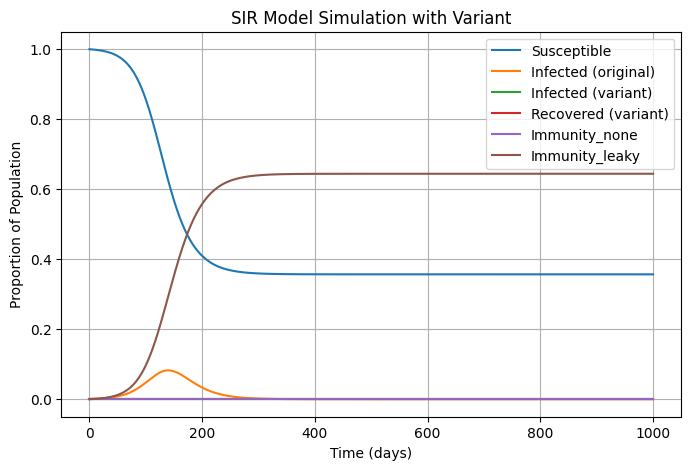

In [ ]:
# set parameter values
#betar = 1.1
Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught

#Rwnaught = betar / gammar # R0 for residents with entIwely susceptible population


betav = 1
gammav = 1
Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Iw0 = 0.001

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later

if (S0+Iw0+Im0+Rv0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]
# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)

# 2. One strain model with no natural immunity using N compartment

N as the recovery compartment, meaning full susceptibility. Pe eventually reach an equilibrium state where rate of recovery matches rate of transmission, but infection never dies out..


Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in P and Iw) is influenced by beta and indIwectly affected by R0 and recovery rate.

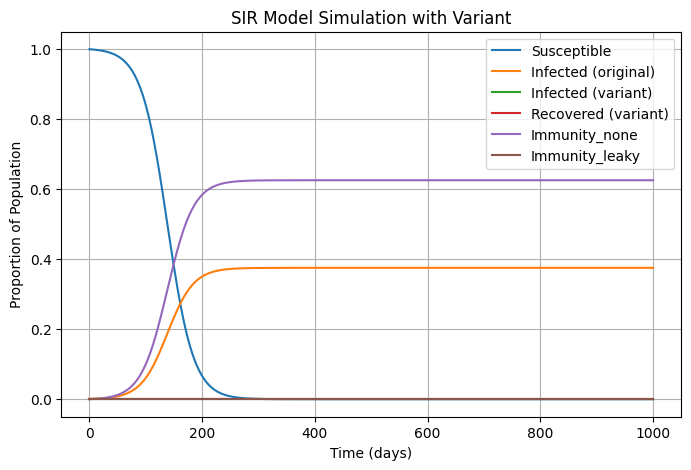

In [ ]:
# set parameter values
#betar = 1.1
Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught
#Rwnaught = betar / gammar # R0 for residents with entIwely susceptible population


betav = 1
gammav = 1
Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 0
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Iw0 = 0.001

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later


if (S0+Iw0+Im0+Rv0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)


# 2.5 One strain model with no natural immunity

P as the only recovery compartment, but with epsilonL = 0, meaning full susceptibility. Pe eventually reach an equilibrium state where rate of recovery matches rate of transmission, but infection never dies out. Behaviour should match the previous scenario exactly when params are the same as well. **SIS


Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in P and Iw) is influenced by beta and indIwectly affected by R0 and recovery rate.

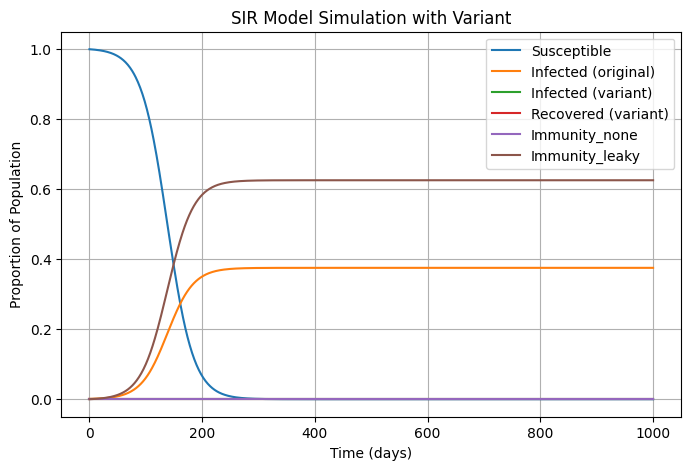

In [ ]:
# set parameter values
#betar = 1.1
Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught
#Rwnaught = betar / gammar # R0 for residents with entIwely susceptible population


betav = 1
gammav = 1
Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 1
epsilonL = 0 #0
t = 1000

# set initial conditions
S0 = 0.999
Iw0 = 0.001

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later


if (S0+Iw0+Im0+Rv0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)




# 3. *One strain model with leaky immunity only

P as the recovery compartment, with leaky susceptibility 0 < epsilon_L < 1. Infection eventually dies out unless at high leakiness (epsilon_L closer to 0).

**define relationship between dying out and leakiness???**


Unlike prior models, where infection dies out because there is nobody left susceptible, infection dying out is contingent on the infected compartment reaching 0 as there is no absorbing compartment.


Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in P and Iw) is influenced by beta and indIwectly affected by R0 and recovery rate.

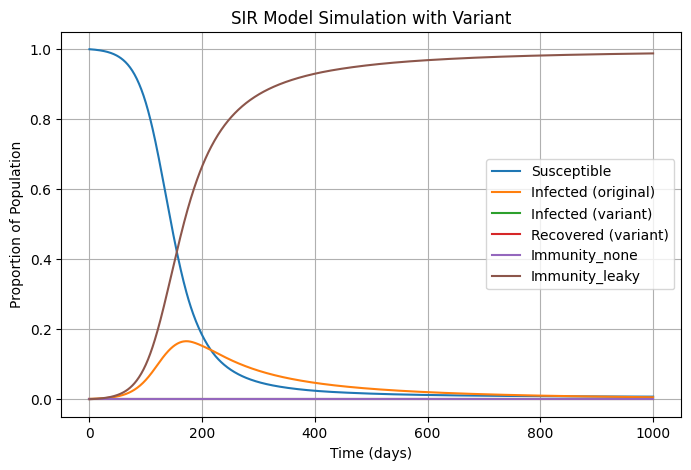

In [ ]:
# set parameter values
#betar = 1.1
Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught
#Rwnaught = betar / gammar # R0 for residents with entIwely susceptible population

betav = 1
gammav = 1
Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 1
epsilonL = 0.4
t = 1000

# set initial conditions
S0 = 0.999
Iw0 = 0.001

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later


if (S0+Iw0+Im0+Rv0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)



# 4. *One strain model with all or nothing protection. epsilon_A = 0.5


Infection dies out because more and more are absorbed into P, perfect protection compartment. This can be seen as P's curve grows visibly more and for longer comparted to N, matching the decrease in infected. Population gradually becomes less susceptible until Iw= 0. Note people in N are still susceptible, though P outweighs N due to P's perfect protection.

Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in P and Iw) is influenced by beta and indIwectly affected by R0 and recovery rate.

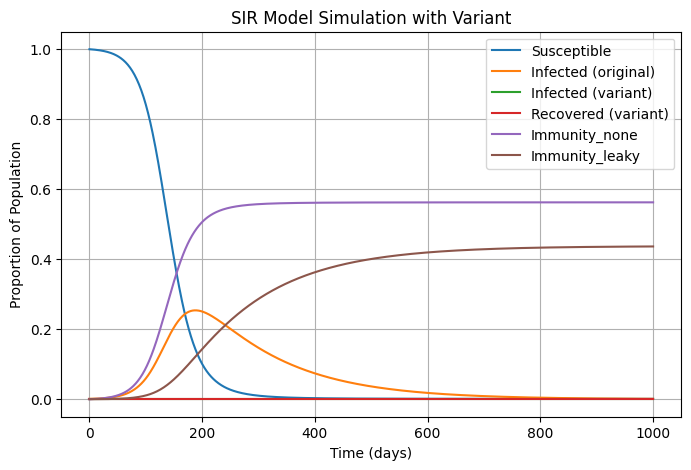

In [ ]:
# set parameter values
#betar = 1.1
Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught
#Rwnaught = betar / gammar # R0 for residents with entIwely susceptible population


betav = 1
gammav = 1
Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 0.1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Iw0 = 0.001

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later


if (S0+Iw0+Im0+Rv0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)

# 5. *One strain model with 2 modes of imperfect protection: leaky [epsilon_L ϵ (0,1) ] and no natural immunity. epsilon_A = 0.5


Infection doesn't die out because (gammaR)(Iw) = BrIw(S+N+(1-Ea)P) —that is, recovery rates match transmission.


Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in P and Iw) is influenced by beta and indIwectly affected by R0 and recovery rate.

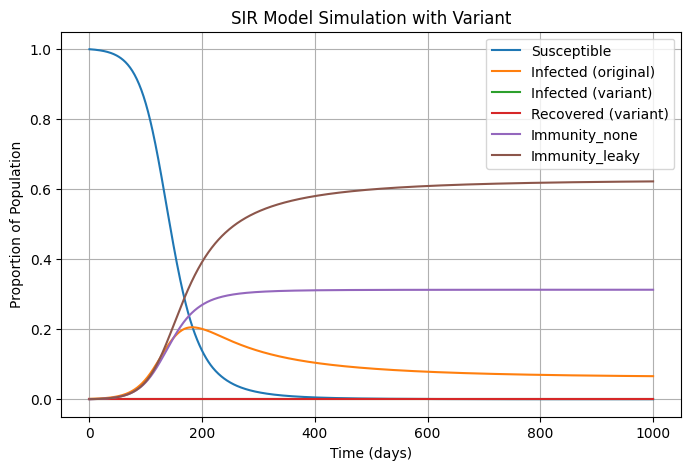

In [ ]:
# set parameter values
#betar = 1.1
Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught
#Rwnaught = betar / gammar # R0 for residents with entIwely susceptible population


betav = 1
gammav = 1
Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 0.5
epsilonL = 0.5
t = 1000

# set initial conditions
S0 = 0.999
Iw0 = 0.001

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later


if (S0+Iw0+Im0+Rv0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)


#RUNNING DIFF IMMUNITIES - 1 strain


In [ ]:
# set parameter values (except epsilon) for all scenarios
#betar = 1.1
Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught
#Rwnaught = betar / gammar # R0 for residents with entIwely susceptible population

mu = 0.6
epsilona = 0.1
epsilonL = 1
t = 1000

betav = 1
gammav = 1
Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

# set initial conditions
S0 = 0.999
Iw0 = 0.001

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later
y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

In [ ]:
one_strain_df = pd.DataFrame(columns=['overall_immunity', 'epsilon_a', 'epsilon_L', 'mu', 'CIw', 'one-wave or endemic', "peak Iw", 'equil_Iw'])


##immunity overall = 1

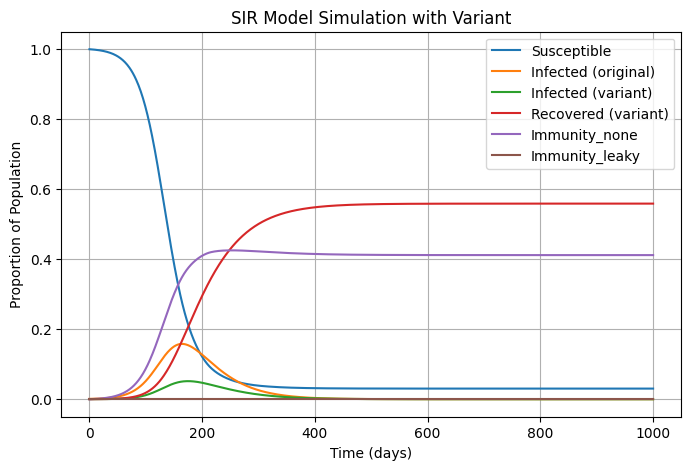

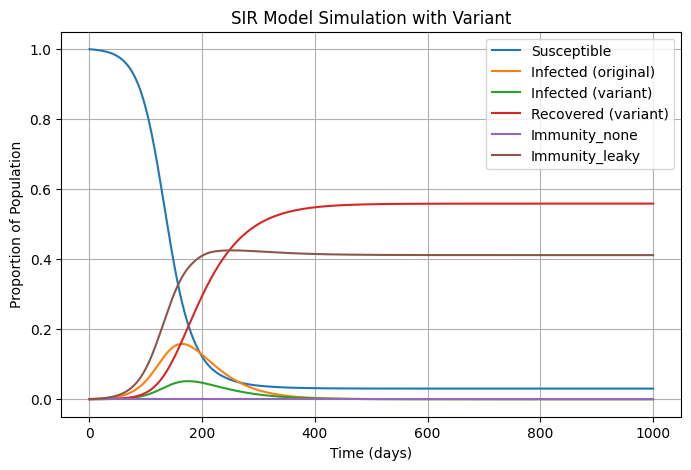

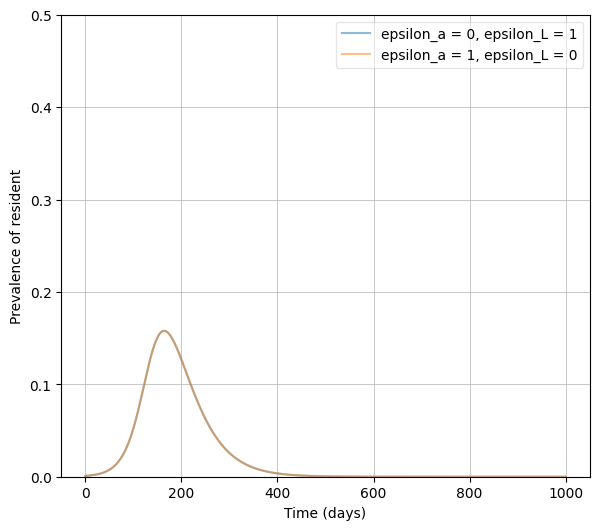

In [ ]:
epsilona_vals = [0, 1]
epsilonL_vals = [1, 0]
kwargs = {}
solutions = []

mu = 0.6
#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(epsilona_vals)):
  epsilona = epsilona_vals[i]
  epsilonL = epsilonL_vals[i]
  solution = solve_ivp(SIR_model_rv,
                      [0,t],
                      y0,
                      args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                      dense_output=True,
                      t_eval=np.linspace(0, t, t + 1),)
  solutions.append(solution)
  kwargs[str(epsilona_vals[i])] = [str(epsilonL_vals[i]), solutions[i]]
  plot_basic(solution)

  #add to df
  one_strain_df.loc[len(one_strain_df)] = [epsilona*epsilonL,
                                epsilona,
                                epsilonL,
                                mu,
                                find_finalCIw(solution),
                                Iw_wave_or_end(solution),
                                find_Iw_peak(solution, Iw_wave_or_end(solution)),
                                find_Iw_equil(solution, Iw_wave_or_end(solution))]



plot_many_eps(two = False, ylim_max = 0.5,**kwargs)


In [ ]:
one_strain_df

,overall_immunity,epsilon_a,epsilon_L,mu,CIw,one-wave or endemic,peak Iw,equil_Iw
0,0,0,1,0.6,1.574952,wave,0.157917,NaN
1,0,1,0,0.6,1.574952,wave,0.157917,NaN


## immunity overall = 0.75



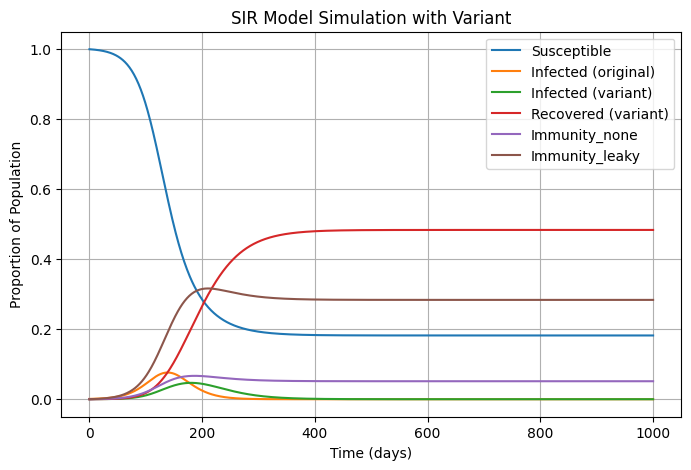

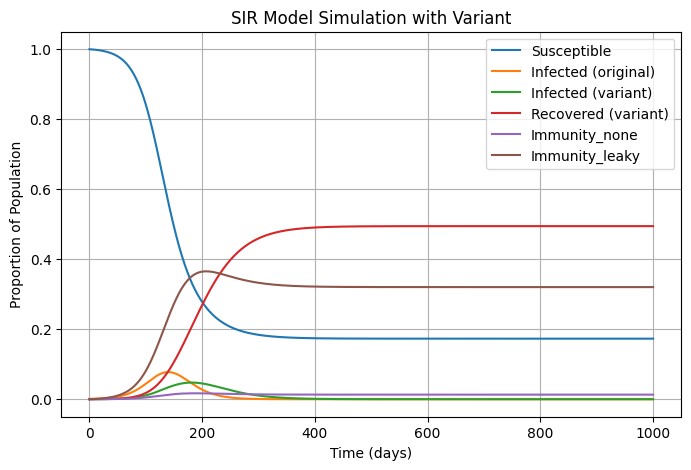

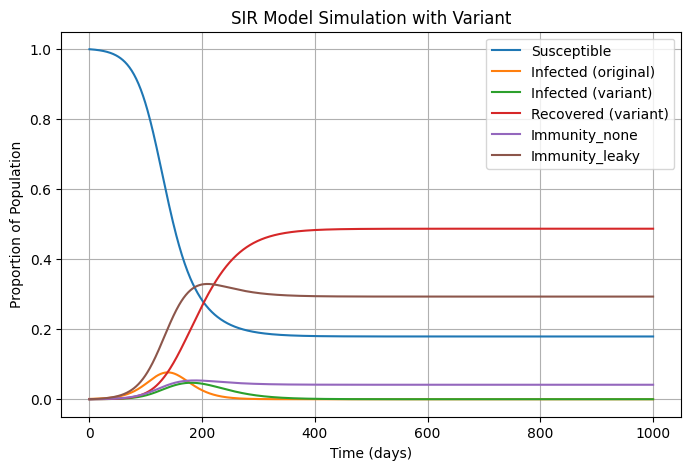

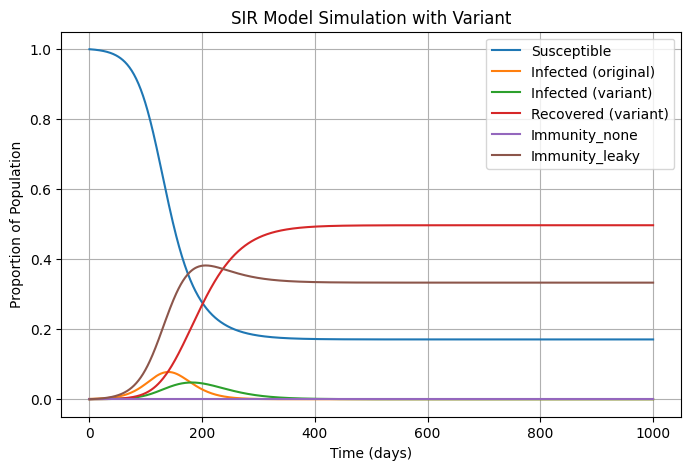

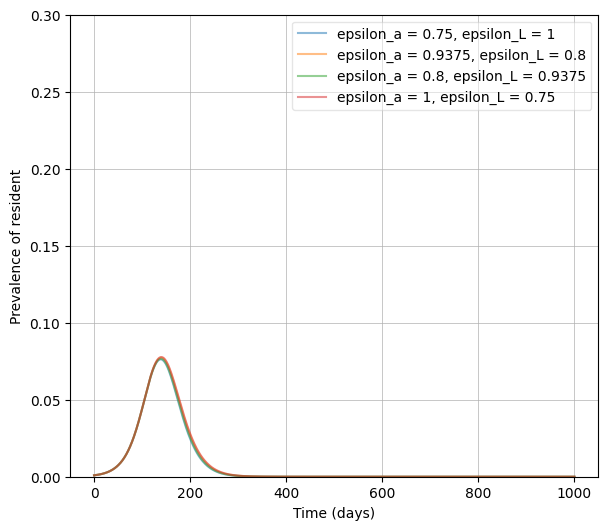

In [ ]:
epsilona_vals = [0.75, 0.9375, 0.8, 1]
epsilonL_vals = [1, 0.8, 0.9375, 0.75]
kwargs = {}
solutions = []
mu = 0.6

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(epsilona_vals)):
  epsilona = epsilona_vals[i]
  epsilonL = epsilonL_vals[i]
  solution = solve_ivp(SIR_model_rv,
                      [0,t],
                      y0,
                      args=(mu, betar, gammar, betav, gammav, epsilona_vals[i], epsilonL_vals[i]),
                      dense_output=True,
                      t_eval=np.linspace(0, t, t + 1),)
  solutions.append(solution)
  kwargs[str(epsilona_vals[i])] = [str(epsilonL_vals[i]), solutions[i]]
  plot_basic(solution)

  #add to df
  one_strain_df.loc[len(one_strain_df)] = [epsilona*epsilonL,
                                epsilona,
                                epsilonL,
                                mu,
                                find_finalCIw(solution),
                                Iw_wave_or_end(solution),
                                find_Iw_peak(solution, Iw_wave_or_end(solution)),
                                find_Iw_equil(solution, Iw_wave_or_end(solution))]
  #make df to add params and graph em

plot_many_eps(two =False, ylim_max = 0.3,**kwargs)



##immunity overall = 0.5

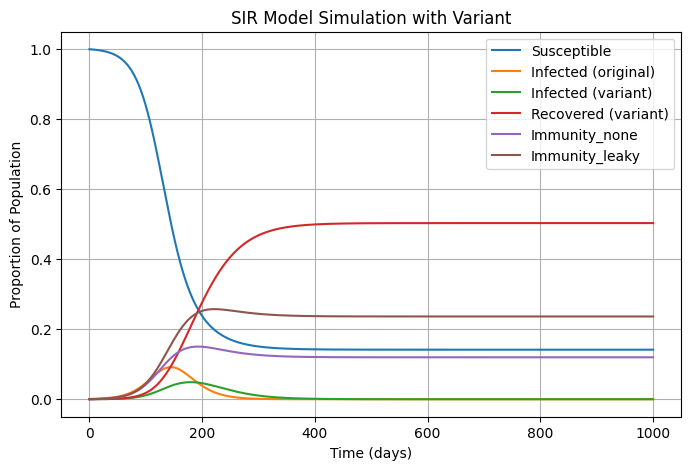

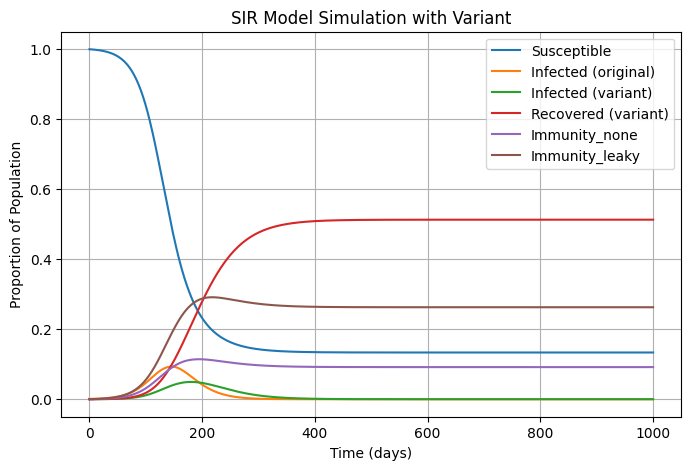

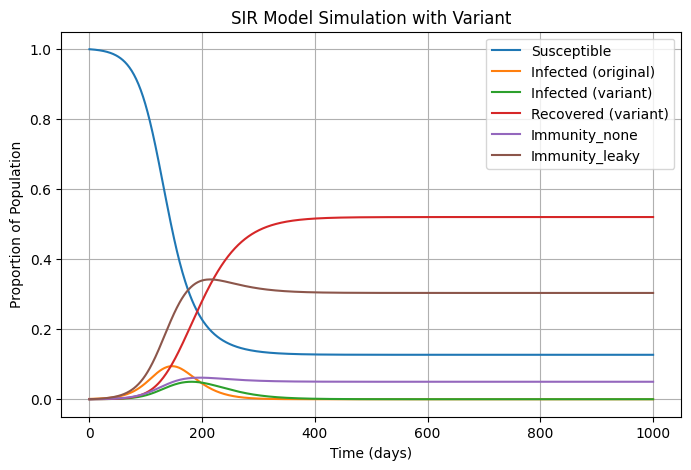

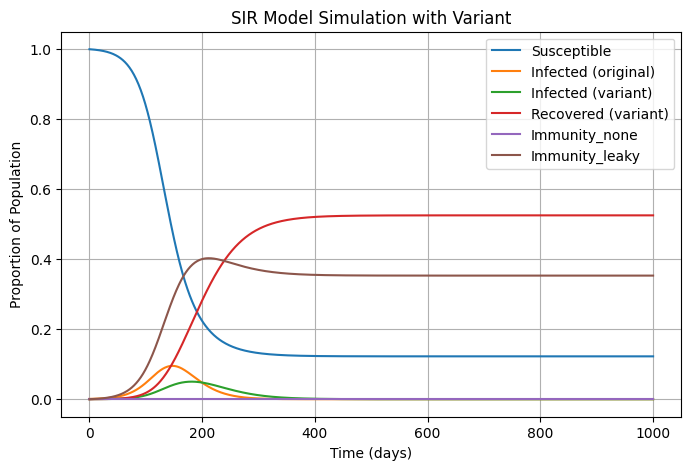

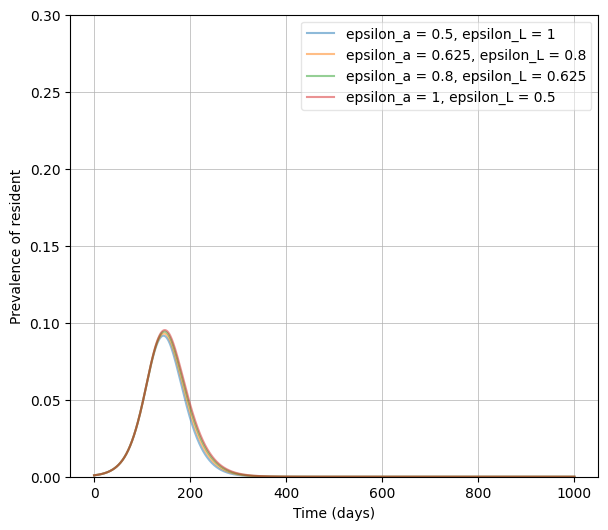

In [ ]:
epsilona_vals = [0.5, 0.625, 0.8, 1]
epsilonL_vals = [1, 0.8, 0.625, 0.5]
kwargs = {}
solutions = []
mu = 0.6

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(epsilona_vals)):
  epsilona = epsilona_vals[i]
  epsilonL = epsilonL_vals[i]
  solution = solve_ivp(SIR_model_rv,
                      [0,t],
                      y0,
                      args=(mu, betar, gammar, betav, gammav, epsilona_vals[i], epsilonL_vals[i]),
                      dense_output=True,
                      t_eval=np.linspace(0, t, t + 1),)
  solutions.append(solution)
  kwargs[str(epsilona_vals[i])] = [str(epsilonL_vals[i]), solutions[i]]
  plot_basic(solution)


  #add to df
  one_strain_df.loc[len(one_strain_df)] = [epsilona*epsilonL,
                                epsilona,
                                epsilonL,
                                mu,
                                find_finalCIw(solution),
                                Iw_wave_or_end(solution),
                                find_Iw_peak(solution, Iw_wave_or_end(solution)),
                                find_Iw_equil(solution, Iw_wave_or_end(solution))]

plot_many_eps(two = False, ylim_max = 0.3,**kwargs)


##immunity overall = 0.25

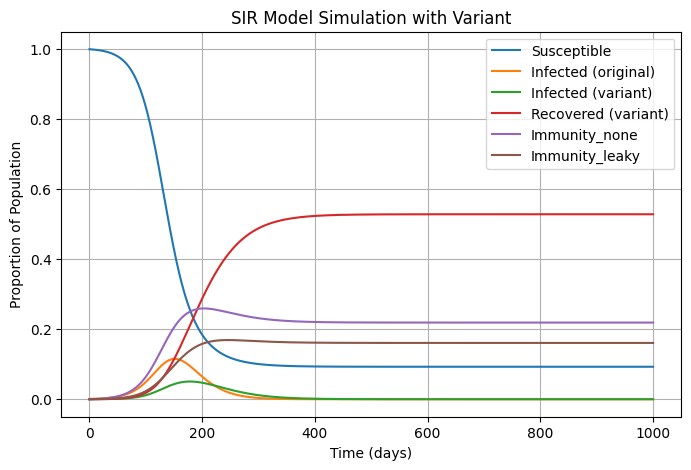

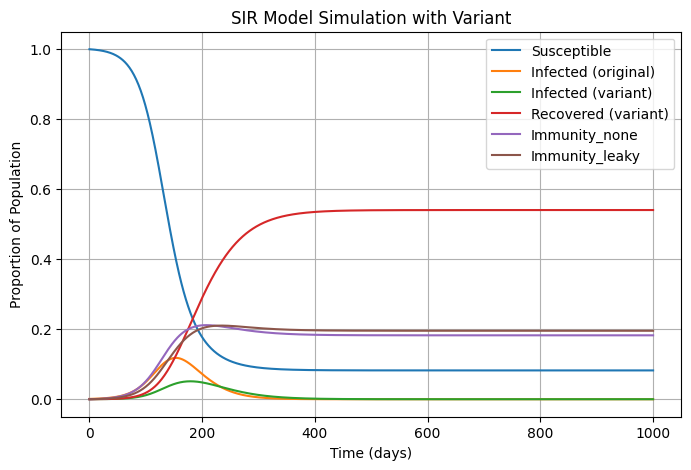

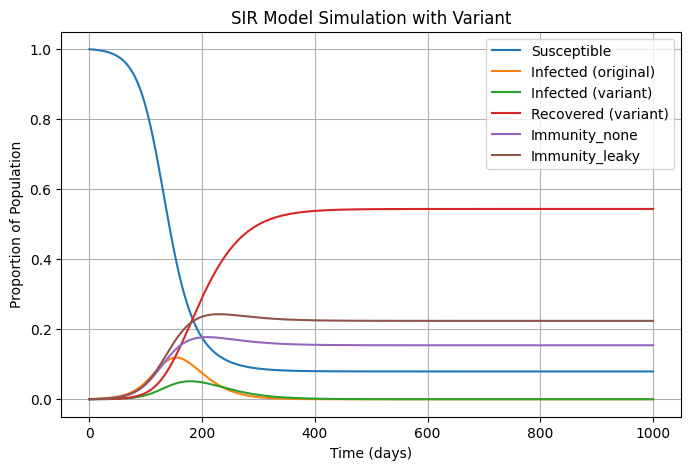

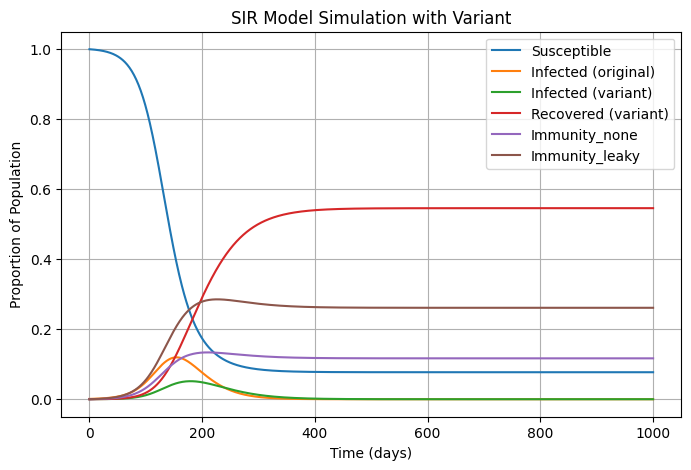

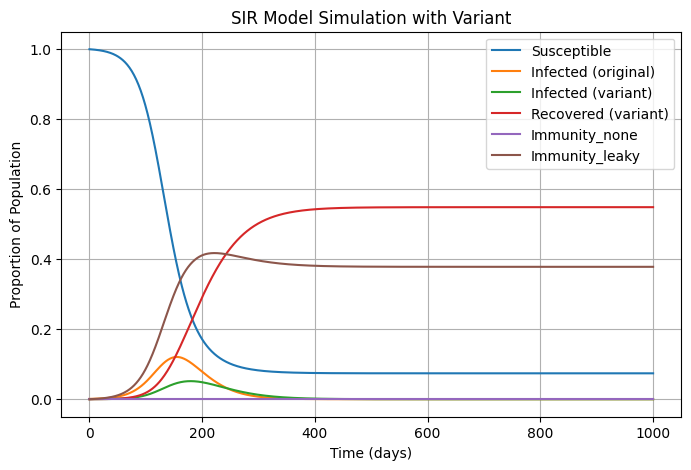

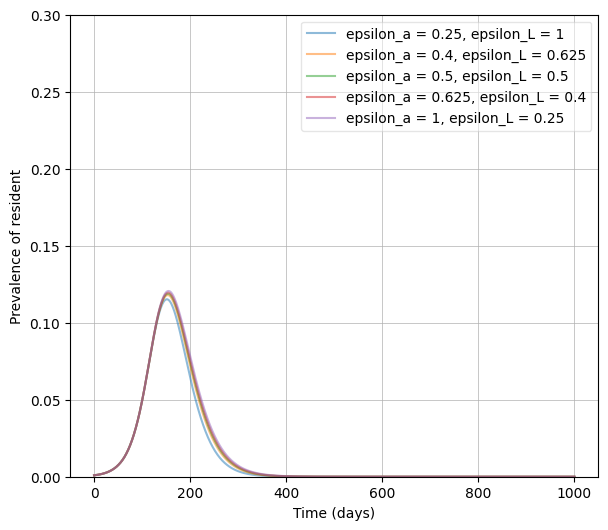

In [ ]:
##immunity overall = 0.5
epsilona_vals = [0.25, 0.4, 0.5, 0.625, 1]
epsilonL_vals = [1, 0.625, 0.5, 0.4, 0.25]
kwargs = {}
solutions = []
mu = 0.6

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(epsilona_vals)):
  epsilona = epsilona_vals[i]
  epsilonL = epsilonL_vals[i]
  solution = solve_ivp(SIR_model_rv,
                      [0,t],
                      y0,
                      args=(mu, betar, gammar, betav, gammav, epsilona_vals[i], epsilonL_vals[i]),
                      dense_output=True,
                      t_eval=np.linspace(0, t, t + 1),)
  solutions.append(solution)
  kwargs[str(epsilona_vals[i])] = [str(epsilonL_vals[i]), solutions[i]]
  plot_basic(solution)


  #add to df
  one_strain_df.loc[len(one_strain_df)] = [epsilona*epsilonL,
                                epsilona,
                                epsilonL,
                                mu,
                                find_finalCIw(solution),
                                Iw_wave_or_end(solution),
                                find_Iw_peak(solution, Iw_wave_or_end(solution)),
                                find_Iw_equil(solution, Iw_wave_or_end(solution))]

plot_many_eps(two = False, ylim_max = 0.3,**kwargs)


In [ ]:
one_strain_df

,overall_immunity,epsilon_a,epsilon_L,mu,CIw,one-wave or endemic,peak Iw,equil_Iw
0,0.00,0.0000,1.0000,0.6,1.574952,wave,0.157917,NaN
1,0.00,1.0000,0.0000,0.6,1.574952,wave,0.157917,NaN
2,0.75,0.7500,1.0000,0.6,0.549686,wave,0.076210,NaN
3,0.75,0.9375,0.8000,0.6,0.570268,wave,0.077411,NaN
4,0.75,0.8000,0.9375,0.6,0.556031,wave,0.076584,NaN
5,0.75,1.0000,0.7500,0.6,0.575561,wave,0.077716,NaN
6,0.50,0.5000,1.0000,0.6,0.685502,wave,0.091579,NaN
7,0.50,0.6250,0.8000,0.6,0.711906,wave,0.093026,NaN
8,0.50,0.8000,0.6250,0.6,0.735377,wave,0.094300,NaN
9,0.50,1.0000,0.5000,0.6,0.752415,wave,0.095221,NaN


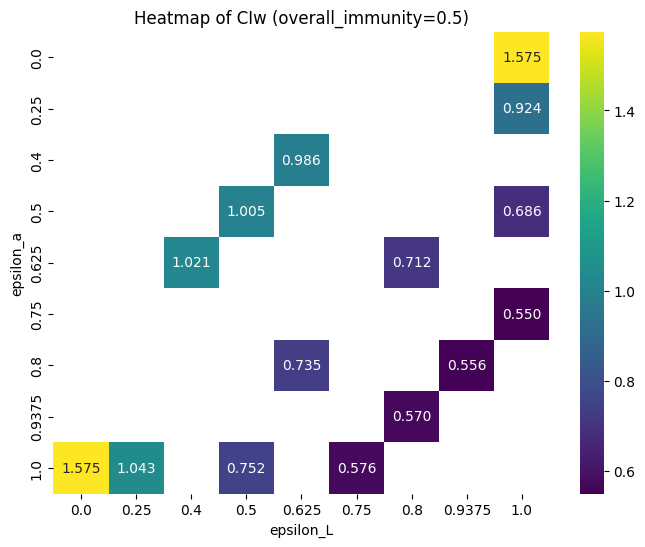

In [ ]:
#dont make a heat map, just facet grid by overall immunity and show diff cum infections and peaks


# 6. Two-strain model, variant exists at t = 0. Natural immunity confers perfect protection against all variants (mu = 0, epsilonL = 1, epsilonA = 1).

Similar to equImalent one-strain model, but both P and R_v absorbs all.

Final epidemic size seems unaffected by changes in mu, but there are changes in P compartment

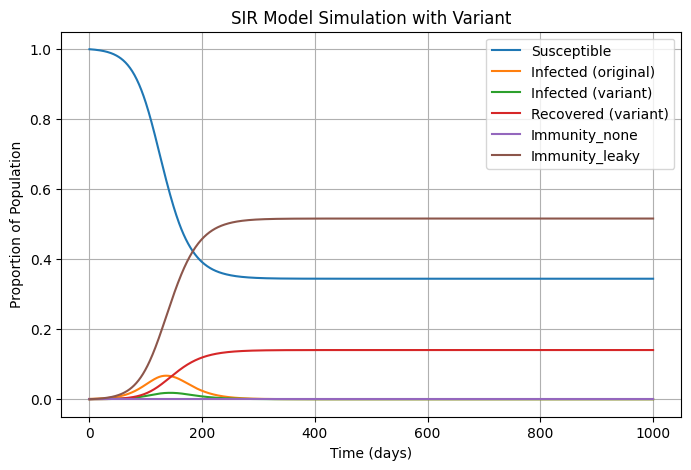

In [ ]:
# set parameter values
#betar = 1.1
Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught
#Rwnaught = betar / gammar # R0 for residents with entIwely susceptible population


Rmnaught = 1.7
gammav = 1/14
betav = Rmnaught*gammav
#Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

mu = 0
epsilona = 1
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Iw0 = 0.0009

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later


if (S0+Iw0+Im0+Rv0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)


# 7. Two-strain model, variant exists at t=0. Natural immunity confers no protection against any variants, all go to N.

Pill see a lot more R_v compared to previous scenario, as the only absorbing compartment. Infected reaches higher final epidemic size and faster as more of the population stays susceptible for longer compared to previous scenario 6.

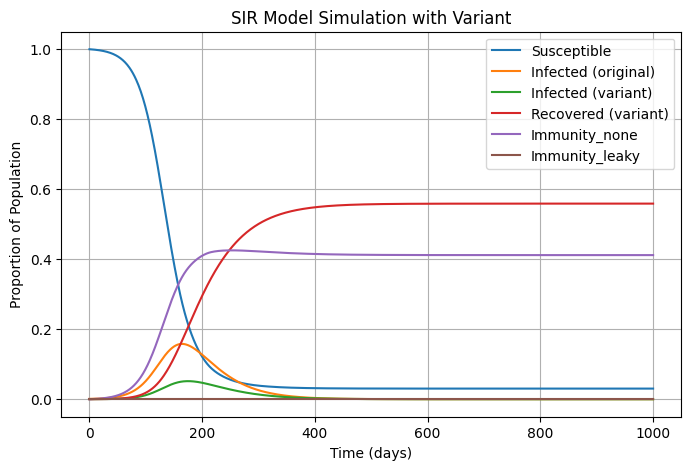

In [ ]:
# set parameter values
#betar = 1.1
Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught
#Rwnaught = betar / gammar # R0 for residents with entIwely susceptible population


Rmnaught = 1.7
gammav = 1/14
betav = Rmnaught*gammav
#Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 0
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Iw0 = 0.0009

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later


if (S0+Iw0+Im0+Rv0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)

plot_basic(solution)



# 8. Two-strain model, variant exists at t=0. All-or-nothing immunity (epsilon_A = 0.5)


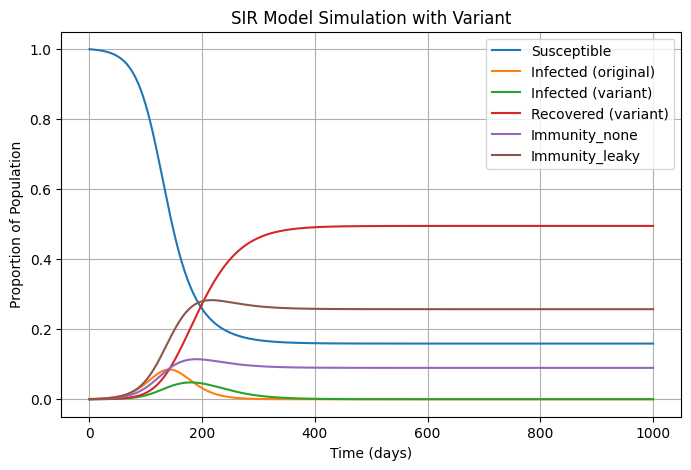

In [ ]:
# set parameter values
#betar = 1.1
Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught
#Rwnaught = betar / gammar # R0 for residents with entIwely susceptible population


Rmnaught = 1.7
gammav = 1/14
betav = Rmnaught*gammav
#Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 0.6
epsilonL = 1
t = 1000

# set initial conditions
S0 = 0.999
Iw0 = 0.0009

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later


if (S0+Iw0+Im0+Rv0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

# Solve the SIR model equations using odeint()
solution_aon = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)
plot_basic(solution_aon)



# 8. Two-strain model, variant exists at t=0. Leaky immunity (epsilon_A = 0.0, epsilon_L ϵ (0,1))

Greater epidemic size than all-or-nothing model

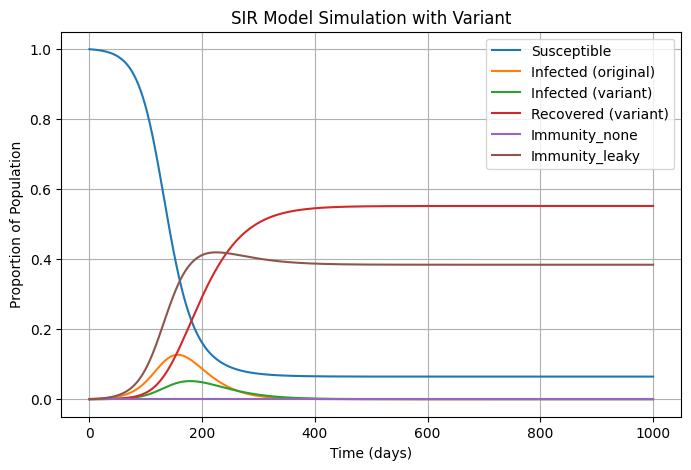

In [ ]:
# set parameter values
#betar = 1.1
Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught
#Rwnaught = betar / gammar # R0 for residents with entIwely susceptible population


Rmnaught = 1.7
gammav = 1/14
betav = Rmnaught*gammav
#Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 1#0
epsilonL = 0.2#0.5
t = 1000

# set initial conditions
S0 = 0.999
Iw0 = 0.0009

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later


if (S0+Iw0+Im0+Rv0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

# Solve the SIR model equations using odeint()
solution_leaky = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona, epsilonL),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)
plot_basic(solution_leaky)


# **COMPARING AoN & LEAKY MODELS**

In [ ]:
# set parameter values that will not be changing

Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught

Rmnaught = 1.7
gammav = 1/14
betav = Rmnaught*gammav
#Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

mu = 0.6
t = 600

# set initial conditions
S0 = 0.999
Iw0 = 0.0009

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later



## total natural immunity = 0.5 = E_a*E_L

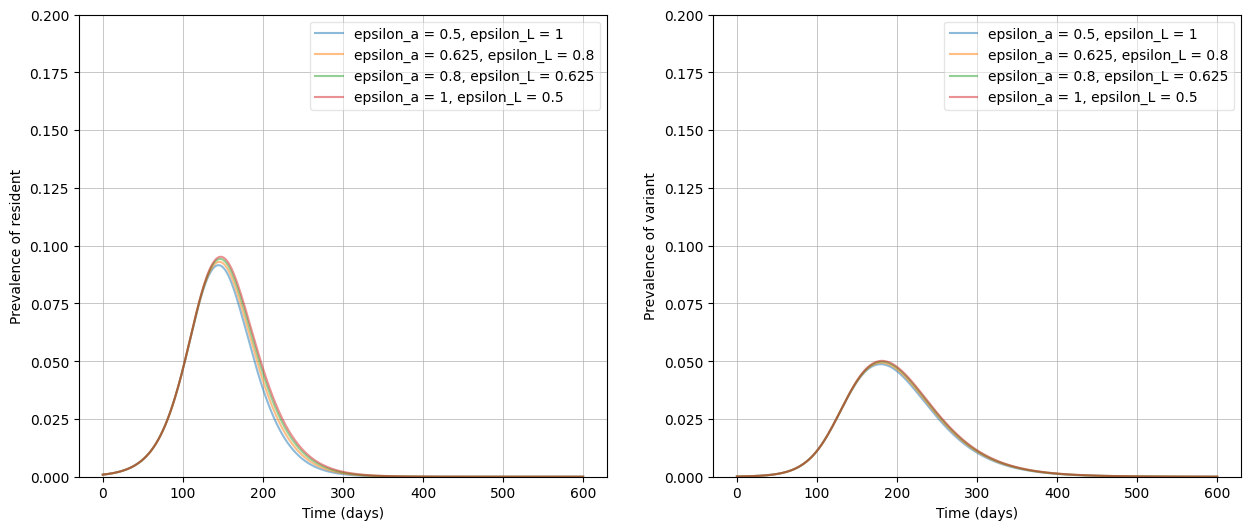

In [ ]:
#list of epsilons. epsilons of the same index can be multiplied to get natural immunity = 0.5 = E_a*E_L
epsilona_vals = [0.5, 0.625, 0.8, 1]
epsilonL_vals = [1, 0.8, 0.625, 0.5]
kwargs = {}
solutions = []

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(epsilona_vals)):
  epsilona = epsilona_vals[i]
  epsilonL = epsilonL_vals[i]
  solution = solve_ivp(SIR_model_rv,
                      [0,t],
                      y0,
                      args=(mu, betar, gammar, betav, gammav, epsilona_vals[i], epsilonL_vals[i]),
                      dense_output=True,
                      t_eval=np.linspace(0, t, t + 1),)
  solutions.append(solution)
  kwargs[str(epsilona_vals[i])] = [str(epsilonL_vals[i]), solutions[i]]

plot_many_eps(ylim_max = 0.2,**kwargs)


In [ ]:
#plot for all infected indIms: relatIme freq of two strains

## total natural immunity = 0.75 = E_a*E_L

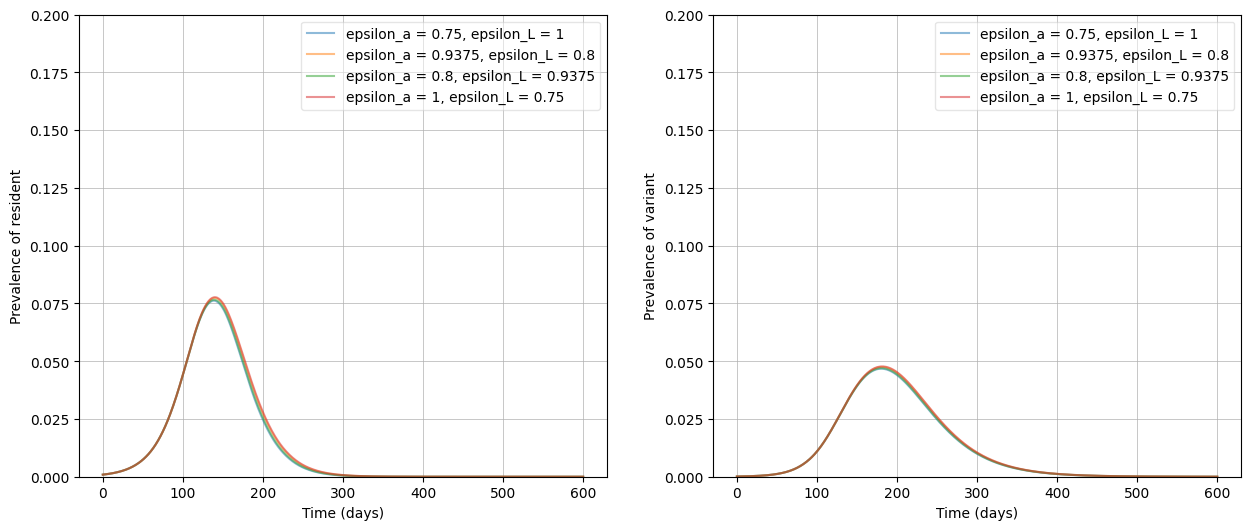

In [ ]:
#list of epsilons. epsilons of the same index can be multiplied to get natural immunity = 0.5 = E_a*E_L
epsilona_vals = [0.75, 0.9375, 0.8, 1]
epsilonL_vals = [1, 0.8, 0.9375, 0.75]
kwargs = {}
solutions = []

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(epsilona_vals)):
  epsilona = epsilona_vals[i]
  epsilonL = epsilonL_vals[i]
  solution = solve_ivp(SIR_model_rv,
                      [0,t],
                      y0,
                      args=(mu, betar, gammar, betav, gammav, epsilona_vals[i], epsilonL_vals[i]),
                      dense_output=True,
                      t_eval=np.linspace(0, t, t + 1),)
  solutions.append(solution)
  kwargs[str(epsilona_vals[i])] = [str(epsilonL_vals[i]), solutions[i]]

plot_many_eps(ylim_max = 0.2, **kwargs)


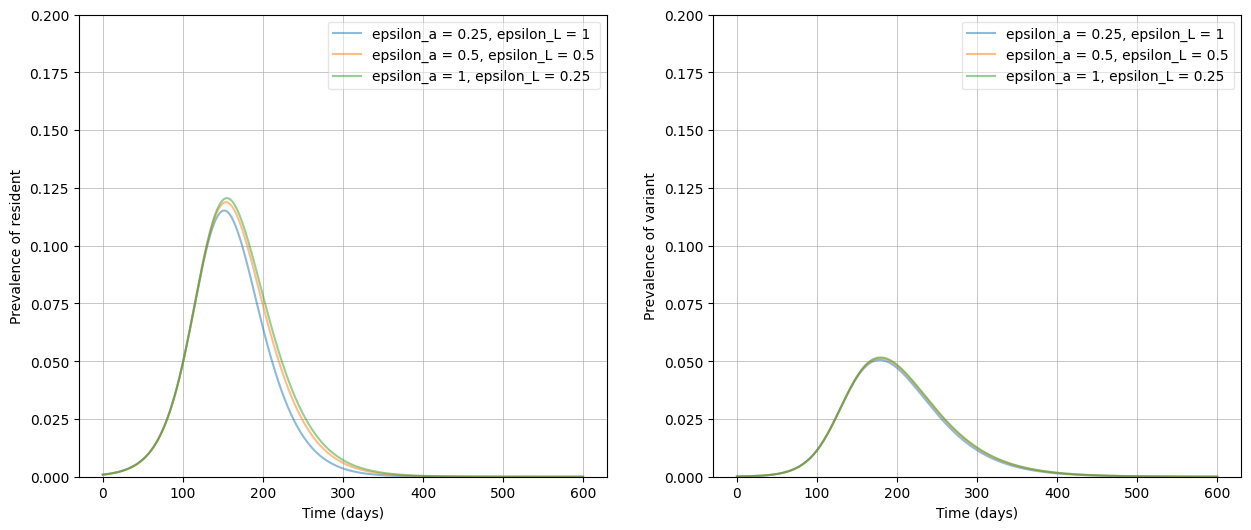

In [ ]:
#list of epsilons. epsilons of the same index can be multiplied to get natural immunity = 0.5 = E_a*E_L
epsilona_vals = [0.25, 0.5, 1]
epsilonL_vals = [1, 0.5, 0.25]
kwargs = {}
solutions = []

y0 = [S0, Iw0, N0, P0, Im0, Rv0, CIw0, CIm0]

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(epsilona_vals)):
  epsilona = epsilona_vals[i]
  epsilonL = epsilonL_vals[i]
  solution = solve_ivp(SIR_model_rv,
                      [0,t],
                      y0,
                      args=(mu, betar, gammar, betav, gammav, epsilona_vals[i], epsilonL_vals[i]),
                      dense_output=True,
                      t_eval=np.linspace(0, t, t + 1),)
  solutions.append(solution)
  kwargs[str(epsilona_vals[i])] = [str(epsilonL_vals[i]), solutions[i]]

plot_many_eps(ylim_max = 0.2,**kwargs)


# **MODULATING MU**

#PERFECT

In [ ]:
# set parameter values that will not be changing

Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught

Rmnaught = 1.7
gammav = 1/14
betav = Rmnaught*gammav
#Rmnaught = betav / gammav # R0 for variant with entIwely susceptible population

epsilona = 1 #1 means go into P: all/leaky; 0 means go into N, nothing
epsilonL = 1 #nat imm efficacy
t = 1000

# set initial conditions
S0 = 0.999
Iw0 = 0.0009

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0) #need to get this seeded later


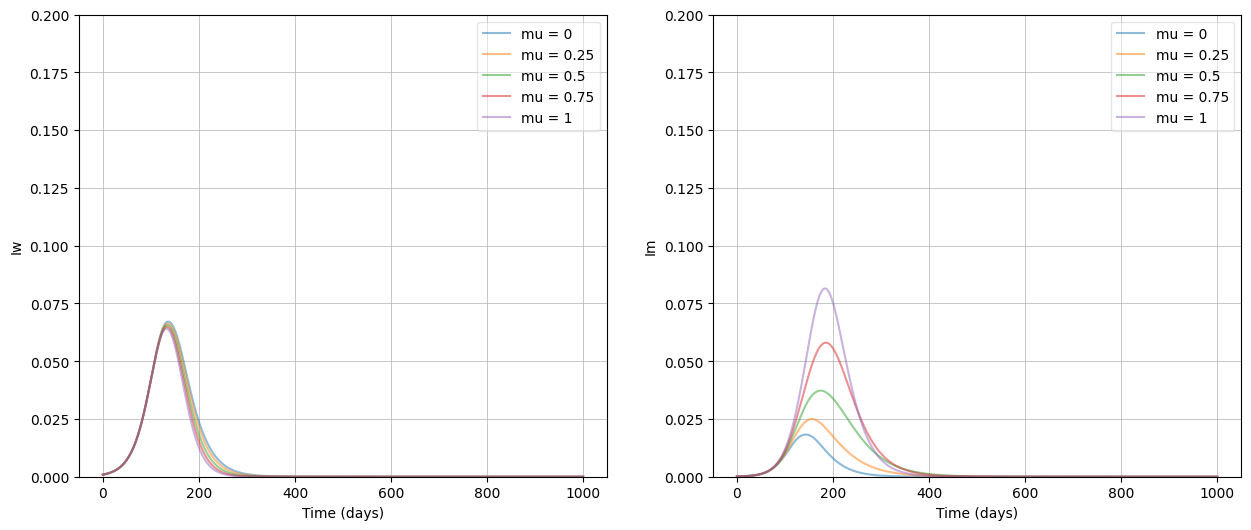

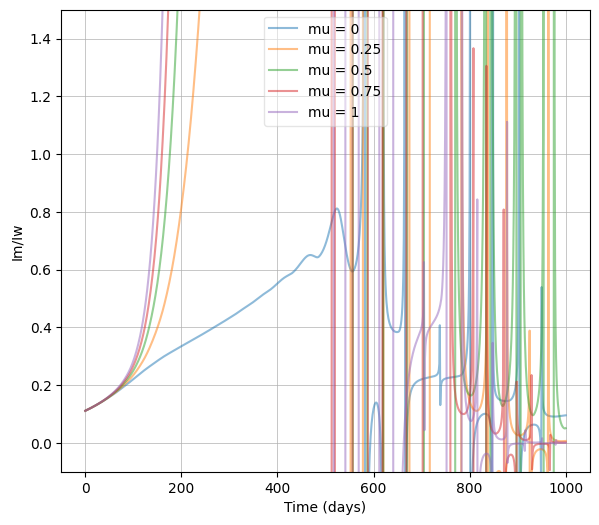

In [ ]:
#list of MU
mu = [0, 0.25, 0.5, 0.75, 1] #mu being degre of immune escape, closer to 1 means more escape

kwargs = {}
solutions = []

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(mu)):

  solution = solve_ivp(SIR_model_rv,
                      [0,t],
                      y0,
                      args=(mu[i], betar, gammar, betav, gammav, epsilona, epsilonL),
                      dense_output=True,
                      t_eval=np.linspace(0, t, t + 1),)
  solutions.append(solution)
  kwargs[str(mu[i])] = solutions[i]

plot_many_mono_anytwo("mu",ylim_max = 0.20,**kwargs)
plot_many_mono_relfreq("mu",ylim_max = 1.5,**kwargs)

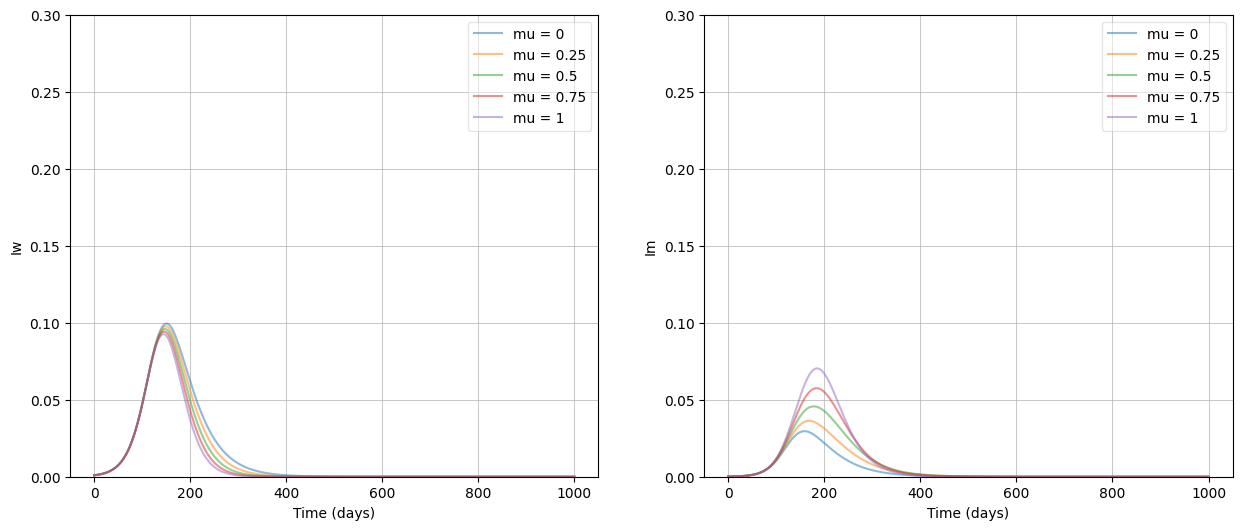

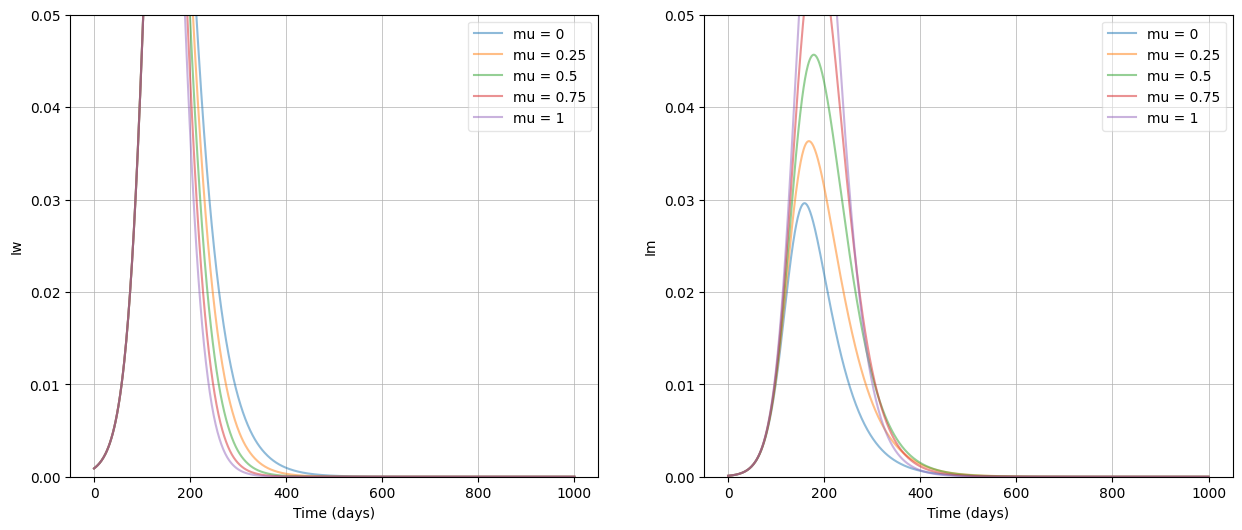

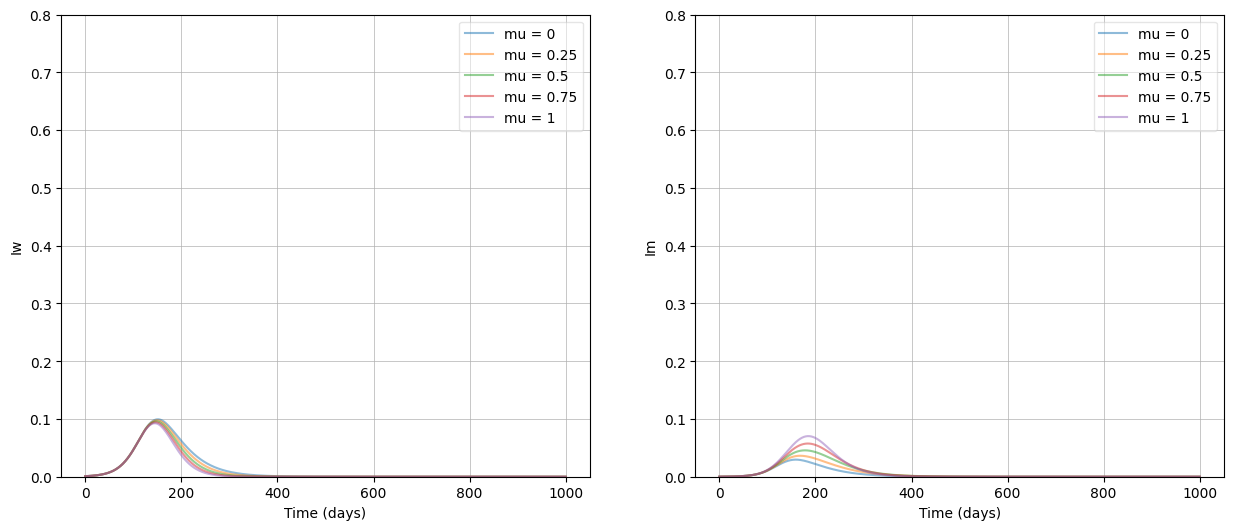

In [ ]:
#ONLT IwCHANGES PHEN ADDING ALL OR NOTHING, leaky doens't change???? even with diff starting Iw??
#list of MU
mu = [0, 0.25, 0.5, 0.75, 1] #mu being degre of immune escape, closer to 1 means more escape

kwargs = {}
solutions = []

epsilona = 1 #1 means go into P: all/leaky; 0 means go into N, nothing
epsilonL = 0.5


Rwnaught = 1.6
gammar = 1/14
betar = gammar*Rwnaught

Rmnaught = 1.7
gammav = 1/14
betav = Rmnaught*gammav

S0 = 0.8
Iw0 = 0.09

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0)

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(mu)):
  solution = solve_ivp(SIR_model_rv,
                      [0,t],
                      y0,
                      args=(mu[i], betar, gammar, betav, gammav, epsilona, epsilonL),
                      dense_output=True,
                      t_eval=np.linspace(0, t, t + 1),)
  solutions.append(solution)
  kwargs[str(mu[i])] = solutions[i]

plot_many_mono_anytwo("mu", ylim_max = 0.3,**kwargs)
plot_many_mono_anytwo("mu",ylim_max = 0.05,**kwargs)
plot_many_mono_anytwo("mu",ylim_max = 0.8,**kwargs)



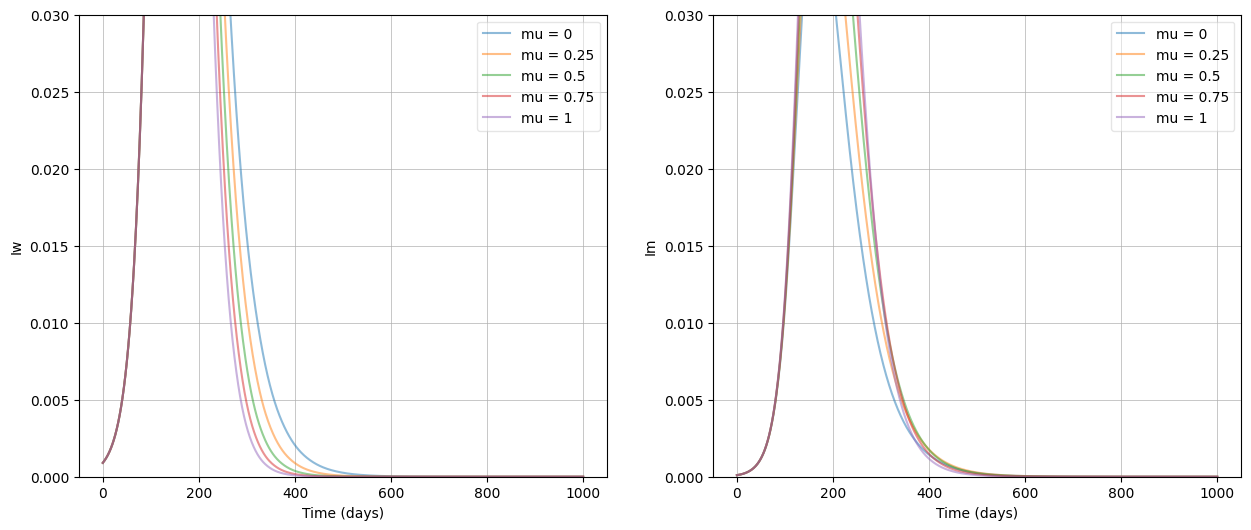

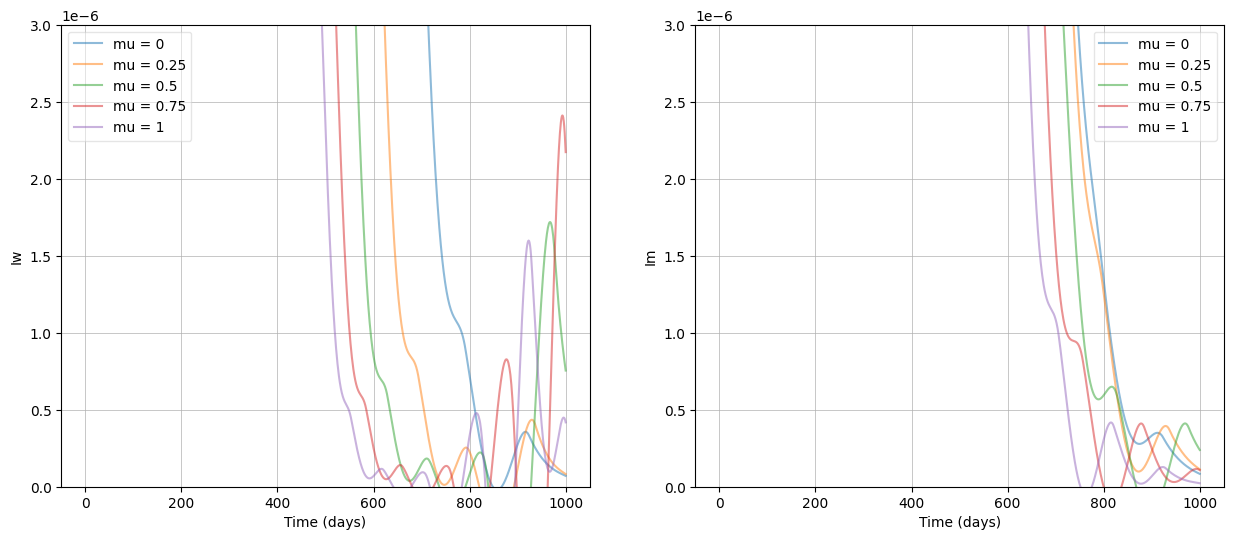

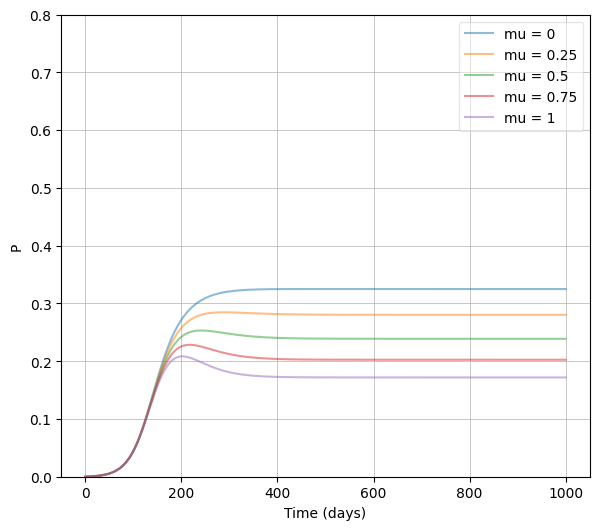

In [ ]:
#ONLT IwCHANGES PHEN ADDING ALL OR NOTHING, leaky doens't change???? even with diff starting Iw??
#list of MU
mu = [0, 0.25, 0.5, 0.75, 1] #mu being degre of immune escape, closer to 1 means more escape

kwargs = {}
solutions = []

epsilona = 0.5 #1 means go into P: all/leaky; 0 means go into N, nothing
epsilonL = 0.5
Rmnaught = 2

S0 = 0.8
Iw0 = 0.09

N0 = 0
P0 = 0

Rv0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rv0)

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(mu)):
  solution = solve_ivp(SIR_model_rv,
                      [0,t],
                      y0,
                      args=(mu[i], betar, gammar, betav, gammav, epsilona, epsilonL),
                      dense_output=True,
                      t_eval=np.linspace(0, t, t + 1),)
  solutions.append(solution)
  kwargs[str(mu[i])] = solutions[i]

plot_many_mono_anytwo("mu",ylim_max = 0.03,**kwargs)
plot_many_mono_anytwo("mu",ylim_max = 0.000003,**kwargs)
plot_many_mono_one("mu","P",ylim_max = 0.8,**kwargs)